In [1]:
##=========================##
##   All imports go here   ##
##=========================##

import logging, math, os, sys, time

import matplotlib as mpl
import numpy      as np
import tensorflow as tf

from pathlib import Path

from tensorflow.keras.callbacks  import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers     import Average, Concatenate, Dense, Embedding, Input, Layer, Masking
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

from mathsformer.tf_objects import (create_custom_objects_dict, AttentionBlock, EncoderBlock, FeedForwardBlock,
                                    LayerActivationRecord, LayerWeightsRecord, PositionalEncoding, ReduceSequence,
                                    RightSlice)


In [2]:
##=======================##
##   Configure logging   ##
##=======================##

##  Create stream to output DEBUG level log messages to stdout
stream = logging.StreamHandler(sys.stdout)
stream.setFormatter(logging.Formatter("%(levelname)7s  %(message)s"))
stream.setLevel(logging.INFO)

##  Get root logger and add our stream handler
logger = logging.getLogger()
logger.addHandler(stream)
logger.setLevel(logging.INFO)


In [3]:
##================================================##
##   Print package versions for reproducibility   ##
##================================================##

logger.info(   "PACKAGE".rjust(15) +  "  |  VERSION")
logger.info("-"*100)
logger.info(    "Python".rjust(15) + f"  |  {sys.version}"      )
logger.info(     "Numpy".rjust(15) + f"  |  {np.__version__}"   )
logger.info("TensorFlow".rjust(15) + f"  |  {tf.__version__}"   )


   INFO          PACKAGE  |  VERSION
   INFO  ----------------------------------------------------------------------------------------------------
   INFO           Python  |  3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
   INFO            Numpy  |  1.23.2
   INFO       TensorFlow  |  2.11.0


In [4]:
##=====================##
##   Create raw data   ##
##=====================##

def generate_raw_dataset(max_int:int=999, include_neg:bool=True, scale:float=1.) :
    '''
    Create dataset where input is str of "A+B" or "A-B", and output is float containing the answer
    A and B are positive or negative integers with maximum amplitude given
    The output is scaled to project it down to ~unity amplitude for stable training
    '''
    if include_neg : singles = np.arange(-max_int, max_int+1, dtype=np.int32) 
    else           : singles = np.arange(0       , max_int+1, dtype=np.int32)
    pairs   = np.array([[(x,y) for x in singles] for y in singles])
    pairs   = np.concatenate(pairs)
    summed  = pairs[:,0] + pairs[:,1]
    minus   = pairs[:,0] - pairs[:,1]
    dataset = []
    for (i1, i2), s, m in zip(pairs, summed, minus) :
        dataset.append((f"{i1}+{i2}", np.float32(s)/scale))     #  , f"{s}"))
        dataset.append((f"{i1}-{i2}", np.float32(m)/scale))     #  , f"{m}"))
    np.random.shuffle(dataset)
    return dataset


In [5]:
##=================================##
##   Create raw data - continued   ##
##=================================##

start_time   = time.time()
raw_dataset  = generate_raw_dataset(299, scale=150)
max_X_length = max([len(s[0]) for s in raw_dataset])
#max_Y_length = max([len(s[1]) for s in raw_dataset])

logger.info(f"Created {len(raw_dataset):,} datapoints in {time.time()-start_time:.1f}s")
logger.info(f"Maximum input sequence length is {max_X_length}")
#logger.info(f"Maximum output sequence length is {max_Y_length}")


   INFO  Created 717,602 datapoints in 1.4s
   INFO  Maximum input sequence length is 9


In [6]:
##=============================================##
##   Convert raw data to tokenised sequences   ##
##=============================================##

tokens = ['M', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '=', 'B', 'E']

vocab_length     = len(tokens)
tokeniser_dict   = dict([(t,i) for i,t in enumerate(tokens)])
detokeniser_dict = dict([(i,t) for i,t in enumerate(tokens)])

def decode_string(x:str) :
    return ''.join([detokeniser_dict[c] for c in x])

def decode_strings(dataset:list) :
    return np.array([decode_string(s).rstrip('M')[1:-1] for s in dataset])

def encode_string(x:str) :
    return [tokeniser_dict[c] for c in x]

def encode_strings(dataset:list, max_length:int=-1) :
    if max_length <= 0 :
        max_length = max([len(x) for x in dataset])
    return np.array([encode_string(f"B{s[:max_length]}E".ljust(max_length+2, 'M')) for s in dataset])

def enumerate_sequence_positions(dataset) :
    if len(dataset.shape) == 2:
        dataset = dataset.reshape(dataset.shape+(1,))
    pos_idcs = np.arange(dataset.shape[1])
    pos_idcs = np.array([pos_idcs for i in range(dataset.shape[0])])
    pos_idcs = pos_idcs.reshape(pos_idcs.shape+(1,))
    return np.concatenate([dataset, pos_idcs], axis=-1)

def raw_dataset_to_tensor(raw_dataset, print_elements=5) :
    logger.debug(f"Raw dataset:\n{raw_dataset[:print_elements]}")
    encoded_dataset = encode_strings(raw_dataset)
    logger.debug(f"Encoded dataset:\n{encoded_dataset[:print_elements]}")
    enumerated_dataset = enumerate_sequence_positions(encoded_dataset)
    logger.debug(f"Enumerated dataset:\n{enumerated_dataset[:print_elements]}")
    return tf.constant(enumerated_dataset, dtype=tf.int32)
    

In [7]:
##=========================================================##
##   Convert raw data to tokenised sequences - continued   ##
##=========================================================##

start_time = time.time()
data_X     = raw_dataset_to_tensor([x[0] for x in raw_dataset], print_elements=3)
data_Y     = tf.constant([[x[1]] for x in raw_dataset], dtype=tf.float32)

split_idx1, split_idx2 = int(0.9*len(data_X)), int(0.95*len(data_X))
train_X, train_Y = data_X[          :split_idx1], data_Y[          :split_idx1]
val_X  , val_Y   = data_X[split_idx1:split_idx2], data_Y[split_idx1:split_idx2]
test_X , test_Y  = data_X[split_idx2:          ], data_Y[split_idx2:          ]

logger.info(f"Data tensors created in {time.time()-start_time:.0f}s")
logger.info(f"  Training data with shape {data_X.shape} and labels {data_Y.shape}")
logger.info(f"Validation data with shape { val_X.shape} and labels { val_Y.shape}")
logger.info(f"      Test data with shape {test_X.shape} and labels {test_Y.shape}")


   INFO  Data tensors created in 2s
   INFO    Training data with shape (717602, 11, 2) and labels (717602, 1)
   INFO  Validation data with shape (35880, 11, 2) and labels (35880, 1)
   INFO        Test data with shape (35881, 11, 2) and labels (35881, 1)


In [43]:
##======================================##
##   Create supervised learning model   ##
##======================================##

def create_model(vocab_length:int, name=None, ndim_model:int=32, ndim_embedding:int=16, num_freqs:int=8, 
                 num_pre_layers:int=1, ndim_pre_layers:int=64, num_encoding_layers:int=4, num_heads:int=6, 
                 ndim_att_hidden:int=32, ndim_ff_hidden:int=64, num_post_layers:int=1, ndim_post_layers:int=64,
                 dropout=0.1, learning_rate:float=0.001, dtype=tf.float32) :
    
    ##  Input layer - Shape [B, S, 2]
    x_in = Input((None,2), dtype=tf.int32, name=f"{name}_input_layer")
    
    ##  Pull out feature for token embedding
    x_embed = RightSlice(slice_index=0, newaxis=False, name=f"{name}_right_slice_token_ID")(x_in)
        
    ##  Token embedding - assuming input feature 0 is the token ID
    ##  Output shape [B, S, ndim_embedding]
    x_embed = Embedding(vocab_length, 
                        ndim_embedding, 
                        mask_zero=True, 
                        dtype=dtype, 
                        name=f"{name}_embedding")(x_embed)
    
    ##  Position encoding - assuming feature input 1 is the token index
    ##  -  Output shape [B, S, 2*num_freqs]
    x_pos = PositionalEncoding(slice_index=1, 
                               num_freqs=num_freqs, 
                               min_period=3, 
                               max_period=100, 
                               dtype=dtype, 
                               name=f"{name}_position_encoding")(x_in)
    
    ##  Combine embedding and position encoding by concatenation
    ##  - Output shape [B, S, ndim_embedding + 2*num_freqs]
    x = Concatenate(name=f"{name}_concat")([x_embed, x_pos])
    
    ##  Do initial pre-processing and collapse to model size
    ##  - use layer_norm instead of batch_norm because tokens in sequence are not independent
    x = FeedForwardBlock(ndim_model, 
                         ndim_hidden=ndim_pre_layers, 
                         num_hidden_layers=num_pre_layers, 
                         dropout=dropout, 
                         layer_norm=True, 
                         batch_norm=False, 
                         dtype=dtype, 
                         name =f"{name}_feedfwd_block_pre_attention")(x)
    
    ##  Run encoder blocks
    for layer_idx in range(num_encoding_layers) :
        x = EncoderBlock(ndim_model, 
                         num_heads, 
                         ndim_att_hidden, 
                         ndim_ff_hidden, 
                         dropout_mha=dropout, 
                         dtype=dtype, 
                         layer_norm=True, 
                         name=f"{name}_encoder_block_{layer_idx+1}")(x)
        
    ##  Contract over the sequence
    x = ReduceSequence(SUM=True, 
                       MEAN=True, 
                       STD=True, 
                       dtype=dtype, 
                       name=f"{name}_reduce_sequence")(x)
        
    ##  Collapse to model size
    x = FeedForwardBlock(1, 
                         ndim_hidden=ndim_post_layers, 
                         num_hidden_layers=num_post_layers, 
                         skip_connect=False, 
                         layer_norm=False, 
                         batch_norm=True, 
                         dtype=dtype, 
                         name=f"{name}_feedfwd_block_post_attention")(x)
    
    ##  Create model
    model = Model(x_in, x, name=name)
    
    ##  Compile model with MSE loss for supervised learning to numerical output
    model.compile(loss="mse", optimizer=Adam(learning_rate=learning_rate))
    
    ##  Return model
    return model
    

In [44]:
##==================================================##
##   Create supervised learning model - continued   ##
##==================================================##

model = create_model(vocab_length, name="supervised_learning_mse")
model.summary()

Model: "supervised_learning_mse"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 supervised_learning_mse_input_  [(None, None, 2)]   0           []                               
 layer (InputLayer)                                                                               
                                                                                                  
 supervised_learning_mse_right_  (None, None)        0           ['supervised_learning_mse_input_l
 slice_token_ID (RightSlice)                                     ayer[0][0]']                     
                                                                                                  
 supervised_learning_mse_embedd  (None, None, 16)    256         ['supervised_learning_mse_right_s
 ing (Embedding)                                                 lice_token_

In [45]:
##=====================================##
##   Train supervised learning model   ##
##=====================================##

##  Create a callback to intermittently record the layer activations
##  -  Since sublayers are not tracked by the computational graph, we cannot access sublayer.output within 
##     a keras function, and therefore we cannot track the activations of sublayers as we may wish
layer_activation_record = LayerActivationRecord(
    batch_frequency = 1000, 
    val_input       = val_X, 
    val_output      = val_Y,
)

##  Create a callback to intermittently record the layer weights
##  -  In this case we can access sublayer weights, and so use recursive=True to monitor all sublayers
layer_weights_record = LayerWeightsRecord(
    batch_frequency = 200, 
    recursive       = True
)

##  Fit the model
model.fit(train_X, train_Y,
          epochs          = 1000,
          batch_size      = 32,
          validation_data = (val_X, val_Y),
          callbacks       = [EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
                             ModelCheckpoint(filepath="supervised_learning_addition_model/model_epoch{epoch:02d}.h5"),
                             layer_activation_record, 
                             layer_weights_record]
         )


Epoch 1/1000
    5/20183 [..............................] - ETA: 4:16 - loss: 4.6593    WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0124s vs `on_train_batch_end` time: 0.0511s). Check your callbacks.
WARNING  Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0124s vs `on_train_batch_end` time: 0.0511s). Check your callbacks.
20183/20183 [==============================] - 435s 21ms/step - loss: 0.1617 - val_loss: 0.0026
Epoch 2/1000
20183/20183 [==============================] - 431s 21ms/step - loss: 0.0693 - val_loss: 0.0015
Epoch 3/1000
20183/20183 [==============================] - 402s 20ms/step - loss: 0.0686 - val_loss: 0.0078
Epoch 4/1000
20183/20183 [==============================] - 414s 20ms/step - loss: 0.0679 - val_loss: 7.7832e-04
Epoch 5/1000
20183/20183 [==============================] - 401s 20ms/step - loss: 0.0660 - val_loss: 0.0130
Epoch 6/1000
20183/20183 [============

In [50]:
##
##  Evaluate model
##

num_bootstrap = 100

test_pred_Y = model(test_X)

sample_weights = tf.random.poisson((num_bootstrap, test_pred_Y.shape[0]), 1)

bootstrap_losses = []
for sample_weight in sample_weights :
    bootstrap_loss = model.compute_loss(
        y = test_Y,
        y_pred = test_pred_Y,
        sample_weight = sample_weight
    )
    bootstrap_losses.append(bootstrap_loss)
    
print(f"Test loss is {np.mean(bootstrap_losses):.6f} +- {np.std(bootstrap_losses):.6f}")

Test loss is 0.000388 +- 0.000004


In [46]:

scale    = 200.
num_test = 30

print("Evaluating text --> number model on the test set:\n")

print("INPUT TEXT".rjust(14) + "TRUE VAL".rjust(14) + "PRED VAL".rjust(14) + "RESIDUAL".rjust(14))
print("-"*60)
for x, true_y, pred_y in zip(decode_strings(test_X[:num_test,:,0].numpy()), 
                             scale*test_Y[:num_test,0].numpy(), 
                             scale*model(test_X[:num_test])[:,0].numpy()) :
    print(x.rjust(14) + f"{true_y:.2f}".rjust(14) + f"{pred_y:.2f}".rjust(14) + f"{pred_y-true_y:.2f}".rjust(14))


Evaluating text --> number model on the test set:

    INPUT TEXT      TRUE VAL      PRED VAL      RESIDUAL
------------------------------------------------------------
       299+-38        348.00        350.27          2.27
       225+137        482.67        482.52         -0.15
      -216-140       -474.67       -469.96          4.70
       246+175        561.33        559.94         -1.39
       -26-282       -410.67       -409.44          1.23
        273+99        496.00        496.25          0.25
      104--157        348.00        343.74         -4.26
       -225-21       -328.00       -321.88          6.12
     -138--280        189.33        192.93          3.60
      109+-192       -110.67       -113.20         -2.54
        -91-29       -160.00       -154.92          5.08
      -181+185          5.33          5.48          0.15
      -158-132       -386.67       -382.96          3.71
        -3--88        113.33        115.07          1.74
      -200-279       -638.67     

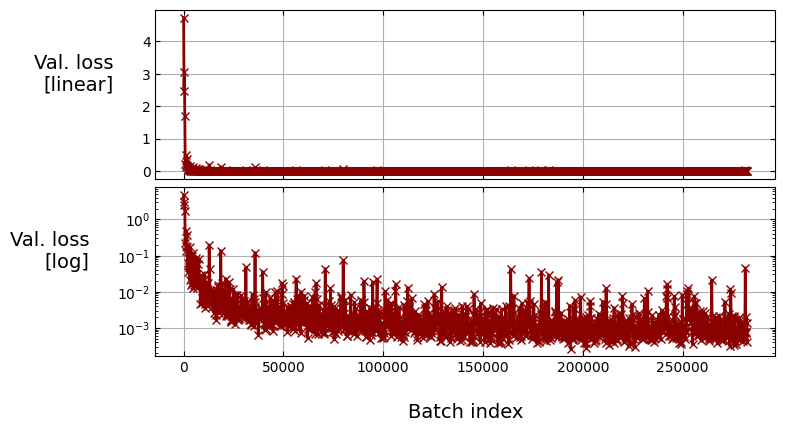

In [47]:

fig = plt.figure(figsize=(8, 4.5))
fig.subplots_adjust(hspace=0.05, wspace=0.3)

ax1 = fig.add_subplot(2, 1, 1)
ax1.tick_params(axis="both", which="both", top=True, right=True, direction="in")
ax1.grid()

ax1.xaxis.set_ticklabels([])
ax1.set_ylabel("Val. loss\n[linear]", ha="right", fontsize=14, labelpad=20, rotation=0)

ax2 = fig.add_subplot(2, 1, 2)
ax2.tick_params(axis="both", which="both", top=True, right=True, direction="in")
ax2.grid()

ax2.set_ylabel("Val. loss\n[log]", ha="right", fontsize=14, labelpad=20, rotation=0)
ax2.set_xlabel("Batch index", va="top", fontsize=14, labelpad=20)

ax1.plot(layer_activation_record.batch_indices, layer_activation_record.val_loss, "x-", lw=2, c="darkred")
ax2.plot(layer_activation_record.batch_indices, layer_activation_record.val_loss, "x-", lw=2, c="darkred")
ax2.set_yscale("log")
plt.show(fig)


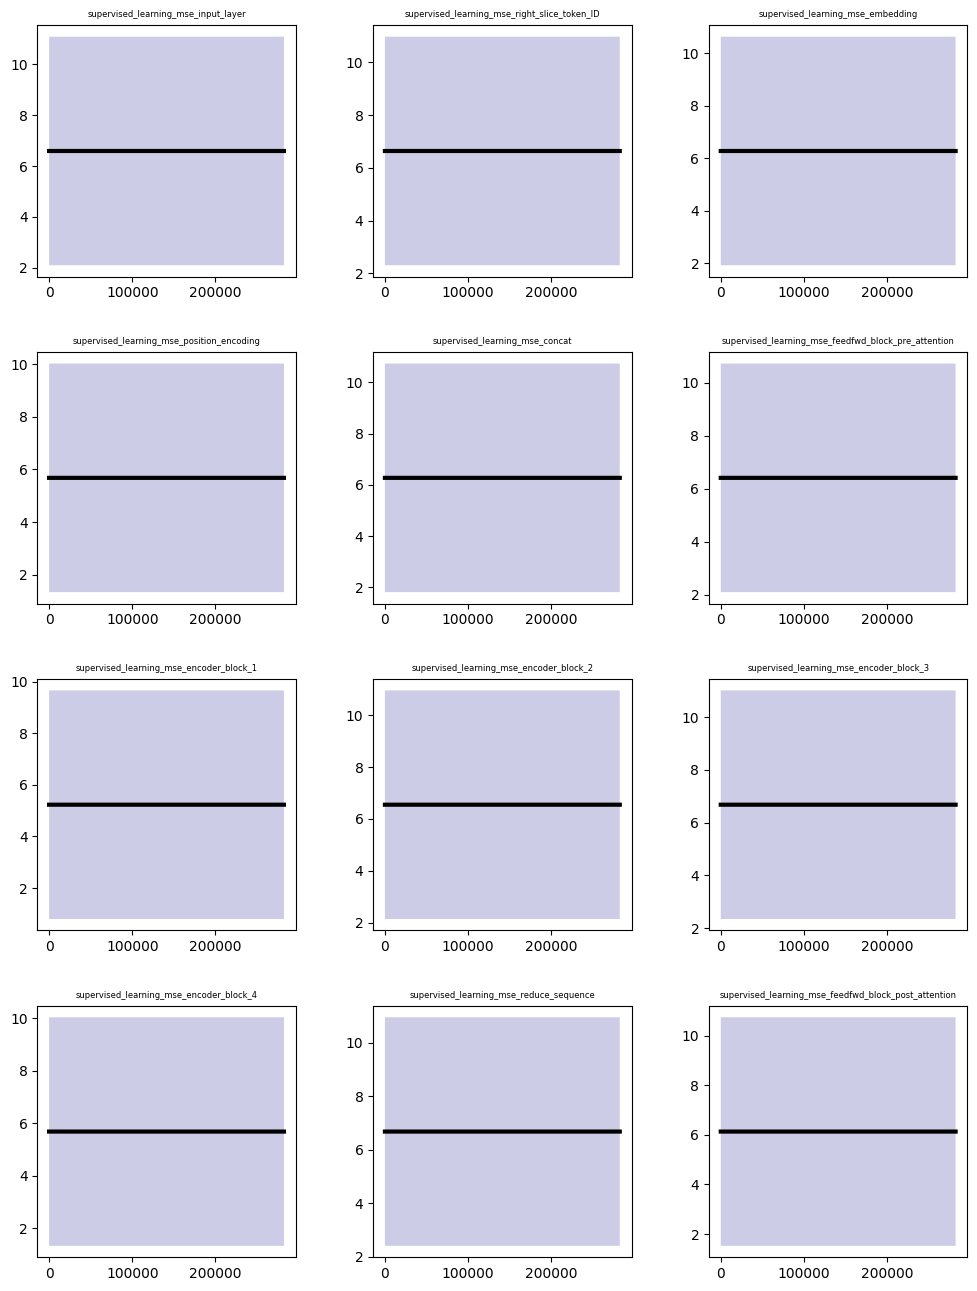

In [48]:

def plot_tracks(record, num_col=3) :
    num_row = math.ceil(len(record.layers) / num_col)

    fig = plt.figure(figsize=(4*num_col, 4*num_row))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for layer_idx, layer in enumerate(record.layers) :
        layer_name = layer.name

        ax  = fig.add_subplot(num_row, num_col, 1+layer_idx)
        ax.set_title(layer_name, fontsize=6)

        x  = np.array(record.batch_indices)
        y  = np.array(record.layer_means[layer_name])
        ey = np.array(record.layer_stds [layer_name])

        if not len(y) : continue

        ax.plot(x, y, "-", lw=3, c='k')
        ax.fill_between(x, y-ey, y+ey, fc="darkblue", alpha=0.2, lw=0)

    plt.show(fig)
    
plot_tracks(layer_activation_record)

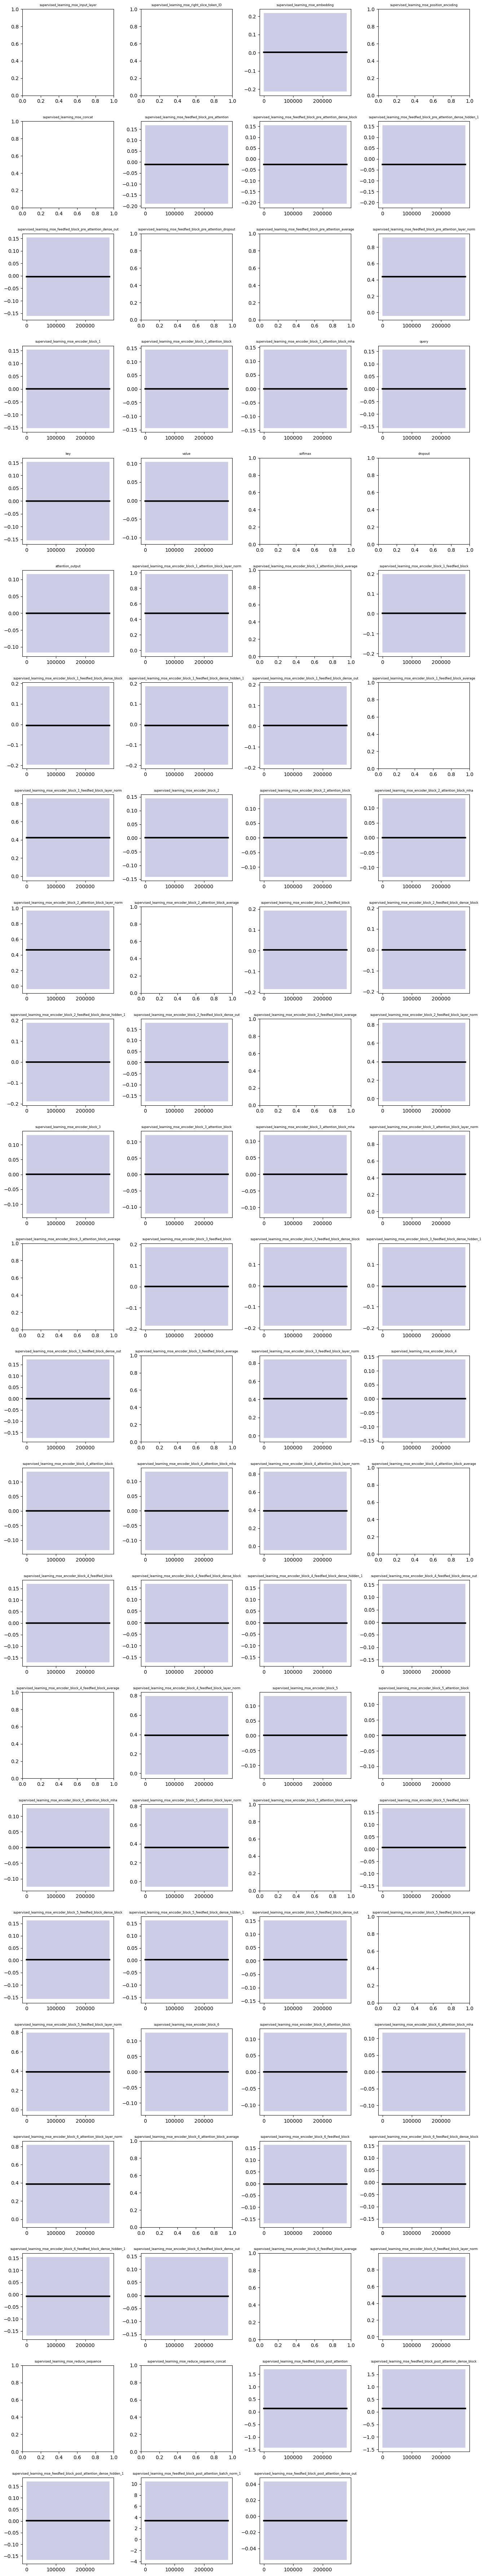

In [49]:
plot_tracks(layer_weights_record, num_col=4)

(0.0032897317, 3.6591948e-05)